In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn import metrics
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("../data/creditcard.csv")

y_class = df["Class"]

df = df.drop(columns= ["Class"])

# 02-exploratory_prep

## Preprocessing pipeline 

### Creare uno standard scaler


In [3]:
X = df.values
y = y_class.values
sss0 = StratifiedShuffleSplit(n_splits=1, test_size=.1, random_state=42)
train_index, test_index = next(iter(sss0.split(X, y)))
X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((256326, 30), (28481, 30), (256326,), (28481,))

In [4]:
print(pd.Series(y_test).value_counts(normalize=1))
print(pd.Series(y_train).value_counts(normalize=1))

0    0.99828
1    0.00172
dtype: float64
0    0.998272
1    0.001728
dtype: float64


In [5]:
classifier = Pipeline([
    ("scat_standard_scaling", StandardScaler()),
    ("feature_selection", SelectFromModel(ExtraTreesClassifier(n_estimators=50, n_jobs=-1, random_state=42, class_weight="balanced", verbose=1))),
    ("classifier", RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42, class_weight="balanced", verbose=1))
], verbose=1)

classifier

Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                n_estimators=50,
                                                                n_jobs=-1,
                                                                random_state=42,
                                                                verbose=1))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, n_jobs=-1,
                                        random_state=42, verbose=1))],
         verbose=1)

In [6]:
classifier.fit(X_train, y_train)

[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   5.6s
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    1.3s remaining:    0.9s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   1.9s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.9s finished


Pipeline(steps=[('scat_standard_scaling', StandardScaler()),
                ('feature_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(class_weight='balanced',
                                                                n_estimators=50,
                                                                n_jobs=-1,
                                                                random_state=42,
                                                                verbose=1))),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=10, n_jobs=-1,
                                        random_state=42, verbose=1))],
         verbose=1)

In [7]:
classifier.steps[0][1].mean_

array([ 9.48144952e+04,  8.07342955e-04,  1.15092963e-04,  1.45939740e-03,
       -1.00495665e-04, -5.95268572e-04, -1.69624508e-04, -6.20705252e-05,
        3.82991612e-04,  2.14066052e-04, -1.11746528e-04,  1.89354208e-04,
        1.03354570e-03, -1.27174191e-04, -2.56317785e-04,  2.18174020e-04,
       -5.94468386e-04,  6.50669588e-04, -6.54016317e-04,  2.09737992e-04,
       -2.87822042e-04,  4.87645160e-04, -1.96086885e-04,  4.51954582e-04,
        1.86887145e-04, -5.93826424e-04,  3.18935724e-04, -1.27453467e-04,
       -1.15217530e-04,  8.82201088e+01])

In [8]:
Y = classifier.predict(X_train)
Y.shape

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


(256326,)

## Model Selection

In [9]:
# TOFIX: y_score 2D, should be 1D for average_precision

# y_score = classifier.predict_proba(X_train)

# print(y_score[:5])

# average_precision = average_precision_score(y_train, y_score)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.1s finished


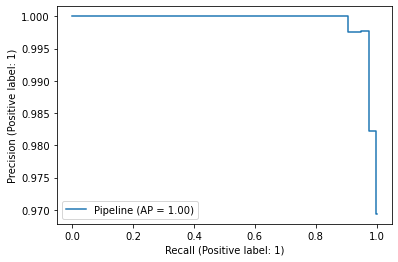

In [16]:

disp = plot_precision_recall_curve(classifier , X_train, y_train)

In [18]:
def score_auc(Y, y_train):
    p, r, tresholds = metrics.precision_recall_curve(
        Y,
        y_train,
    )
    metric = metrics.auc(p, r)
    return 1 - metric

score_auc(Y, y_train)

0.027659924244157086

## Auto-optim

In [19]:
model_scorer = metrics.make_scorer(score_func=score_auc)
# Cross-validation score

In [29]:
param_grid = {
    "classifier__n_estimators": [5, 10, 20],
}
search = GridSearchCV(classifier, param_grid=param_grid, n_jobs=-1, verbose=1, scoring=model_scorer)
search.fit(X_train, y_train)

print(search.best_score_)
print(search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Pipeline]  (step 1 of 3) Processing scat_standard_scaling, total=   0.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Pipeline] . (step 2 of 3) Processing feature_selection, total=   5.1s
[Pipeline] ........ (step 3 of 3) Processing classifier, total=   1.2s
0.15284856932711466
{'classifier__n_estimators': 5}
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
